# training_test.ipynb 기반으로 전체데이터에 맞춰 학습코드 작성
- trocr tokenizer로 CER validation 단계에서 zerodivision error 발생.
- 다시 학습코드 수정 -> trocr_training_inference__code tokenizer.ipynb

In [1]:
import pandas as pd
df = pd.read_csv('halfdata/cropped_image_half.csv')
df

,original_img_name,text,bbox,bbox 높이에 대한 너비 비,text_length,file_name
0,medicine_31215.jpg,건강,"[270.7996407778658, 181.6060866848643, 85.8899...",1.729167,2,medicine_31215_0.jpg
1,medicine_31215.jpg,기능식품,"[231.2671741729349, 237.28789101405005, 163.89...",3.250000,4,medicine_31215_1.jpg
2,medicine_31215.jpg,MADE,"[2084.202921282695, 176.46746671166335, 243.71...",3.909091,4,medicine_31215_2.jpg
3,medicine_31215.jpg,IN,"[2334.8476798738207, 183.39483441141803, 98.24...",1.677419,2,medicine_31215_3.jpg
4,medicine_31215.jpg,USA,"[2444.426041669941, 185.91387721132884, 150.51...",2.366337,3,medicine_31215_4.jpg
...,...,...,...,...,...,...
50995,medicine_32162.jpg,"plantarum,","[1025.4162565427919, 666.2598973080914, 286.08...",4.068966,10,medicine_32162_12.jpg
50996,medicine_32162.jpg,"paracasei,","[1676.3878095347584, 665.0476597792422, 259.41...",3.754386,10,medicine_32162_13.jpg
50997,medicine_32162.jpg,Streptococ-,"[1949.1412535258057, 665.0476597792422, 311.54...",5.586957,11,medicine_32162_14.jpg
50998,medicine_32162.jpg,cus,"[134.4216728387039, 747.479811740981, 94.55452...",1.950000,3,medicine_32162_15.jpg


In [2]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=32): # max_target_length 낮출 필요 있음.
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [4]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
train_dataset = IAMDataset(root_dir='halfdata/cropped_image_half/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='halfdata/cropped_image_half/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 40800
Number of validation examples: 10200


In [6]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])


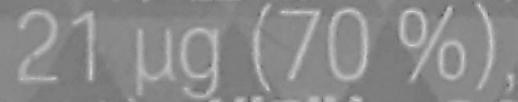

In [7]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [8]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

21ug(70%),


In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

# Train model

In [10]:
torch.cuda.is_available()

True

In [11]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-printed')
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [12]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
!pip install datasets jiwer

In [13]:
from datasets import load_metric
cer_metric = load_metric("cer")

/tmp/ipykernel_1355/1679503157.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [14]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # 빈문자열 제거
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [15]:
from transformers import AdamW
from tqdm.notebook import tqdm
import csv

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(5):  # loop over the dataset multiple times
   # train
  model.train()
  train_loss = 0.0
  for batch in tqdm(train_dataloader):
    # get the inputs
    for k,v in batch.items():
      batch[k] = v.to(device)

    # forward + backward + optimize
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()

  print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
  model.eval()
  valid_cer = 0.0
  with torch.no_grad():
    for batch in tqdm(eval_dataloader):
      # run batch generation
      outputs = model.generate(batch["pixel_values"].to(device))
      # compute metrics
      cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
      valid_cer += cer

  print("Validation CER:", valid_cer / len(eval_dataloader))


  with open('result.csv', 'a') as f:
    data = [{'epoch': epoch, 'loss': train_loss/len(train_dataloader), 'Validation CER':  valid_cer / len(eval_dataloader) }]
    writer = csv.DictWriter(f, fieldnames=data[0].keys()) # fieldnames=['Name', 'Height']
    if epoch == 0:
        writer.writeheader()  # 첫 번째 루프에서만 헤더 쓰기
    writer.writerows(data)

  model.save_pretrained("./model/")

/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10200 [00:00<?, ?it/s]

Loss after epoch 0: 0.581779404088299


  0%|          | 0/2550 [00:00<?, ?it/s]

/home/wooju/anaconda3/envs/py39_trocr/lib/python3.9/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


ZeroDivisionError: division by zero

In [16]:
outputs

tensor([[  0,   0, 190,   3,   2],
        [  0,   0, 190,   3,   2],
        [  0,   0, 190,   3,   2],
        [  0,   0, 190,   3,   2]], device='cuda:0')

In [17]:
batch["labels"]

tensor([[  0, 190,   3,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1],
        [  0, 190,   3,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1],
        [  0, 190,   3,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1],
        [  0, 190,   3,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1]])

In [18]:
compute_cer(pred_ids=outputs, label_ids=batch["labels"])

ZeroDivisionError: division by zero

In [31]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
  for batch in tqdm(eval_dataloader):
    # run batch generation
    outputs = model.generate(batch["pixel_values"].to(device))
    # compute metrics
    cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
    valid_cer += cer

print("Validation CER:", valid_cer / len(eval_dataloader))


with open('trainresult.csv', 'a') as f:
  data = [{'epoch': epoch, 'loss': train_loss/len(train_dataloader), 'Validation CER':  valid_cer / len(eval_dataloader) }]
  writer = csv.DictWriter(f, fieldnames=data[0].keys()) # fieldnames=['Name', 'Height']
  if epoch == 0:
      writer.writeheader()  # 첫 번째 루프에서만 헤더 쓰기
  writer.writerows(data)

model.save_pretrained("./model/")

  0%|          | 0/2550 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.14255379111429528
